<a href="https://colab.research.google.com/github/rahiakela/genai-research-and-practice/blob/main/hands-on-generative-ai-with-transformers-and-diffusion-models/05_stable_diffusion_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [1]:
%%capture

!pip install genaibook
!pip install datasets

In [22]:
import datasets
import diffusers
import transformers
import huggingface_hub

import torch
from torch import nn
from torch.nn import functional as F
from torchvision import transforms
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
import torchvision

from diffusers import DDPMPipeline
from diffusers import DDPMScheduler
from diffusers import UNet2DModel
from diffusers import StableDiffusionPipeline
from diffusers import StableDiffusionInpaintPipeline

from datasets import load_dataset

from genaibook.core import get_device
from genaibook.core import plot_noise_and_denoise
from genaibook.core import show_images
from genaibook.core import load_image, SampleURL
from genaibook.core import plot_scheduler

import pandas as pd
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from tqdm import tqdm

In [3]:
datasets.logging.set_verbosity_error()
diffusers.logging.set_verbosity_error()
transformers.logging.set_verbosity_error()
huggingface_hub.logging.set_verbosity_error()

In [4]:
device = get_device()

## Dataset

In [ ]:
fashion_mnist = load_dataset("fashion_mnist")

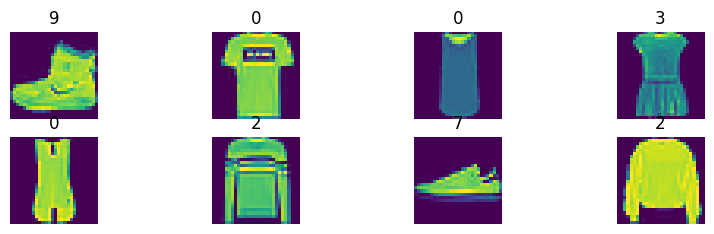

In [ ]:
clothes = fashion_mnist["train"]["image"][:8]
classes = fashion_mnist["train"]["label"][:8]

show_images(clothes, titles=classes, figsize=(10, 2.5))

In [ ]:
# Define transformations
preprocess = transforms.Compose(
   [
      transforms.RandomHorizontalFlip(),            # Randomly flip (data augmentation)
      transforms.ToTensor(),                        # Convert to tensor (0, 1)
      transforms.Pad(2),                            # Add 2 pixels on all sides
      transforms.Normalize([0.5], [0.5]),           # Map to (-1, 1)
   ]
)

In [ ]:
def transform(examples):
  images = [preprocess(image) for image in examples["image"]]
  return {"images": images, "labels": examples["label"]}

train_dataset = fashion_mnist["train"].with_transform(transform)

In [ ]:
batch_size = 256

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

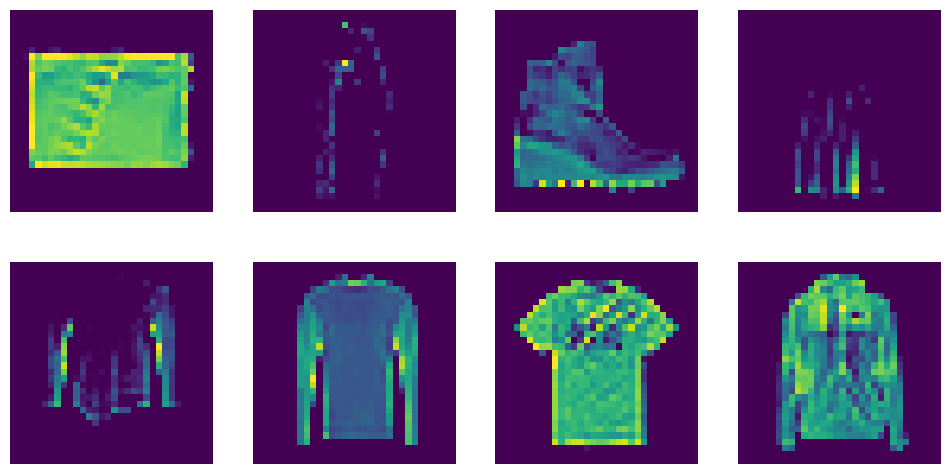

In [ ]:
# let's load a batch and inspecting the images
batch = next(iter(train_dataloader))

# When we normalized, we mapped (0, 1) to (-1, 1)
# Now we map back to (0, 1) for display
show_images((batch["images"][:8] * 0.5 * 0.5).clip(0, 1))

##Class-Conditioned Model

In [ ]:
# let's create a UNet and feed our batch of noisy images through it
model = UNet2DModel(
    sample_size=32, # Specify our input size
    in_channels=1,  # 1 channel for grayscale images
    out_channels=1, # 1 channel for grayscale images
    block_out_channels=(32, 64, 128, 256), # How many channels each block will have
    num_class_embeds=10, # Enable class conditioning
)

In [ ]:
# Pass a batch of data and the class labels as additional through to make sure it works
x = torch.randn((1, 1, 32, 32))
with torch.inference_mode():
  output = model(x, timestep=7, class_labels=torch.tensor([2])).sample
print(output.shape)

torch.Size([1, 1, 32, 32])


###Training

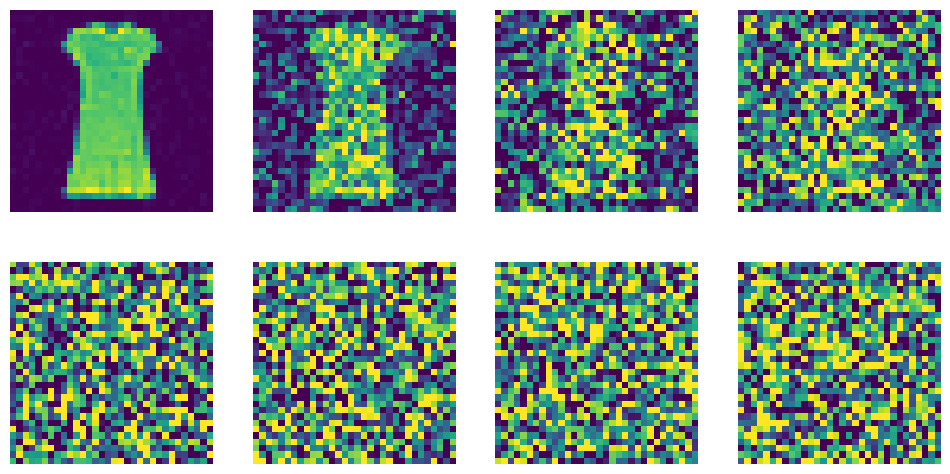

In [ ]:
# Initialize the scheduler
scheduler = DDPMScheduler(
    num_train_timesteps=1000,
    beta_start=0.001,
    beta_end=0.02,
)

# Sample a random timestep for each image
timesteps = torch.linspace(0, 999, 8).long()
batch = next(iter(train_dataloader))

# We load 8 images from the dataset and add increasing amounts of noise to them
x = batch["images"][0].expand([8, 1, 32, 32])
noise = torch.randn_like(x)
noised_x = scheduler.add_noise(x, noise, timesteps)

show_images((noised_x * 0.5 + 0.5).clip(0, 1))

In [ ]:
num_epochs = 25 # How many runs through the data should we do?
lr = 3e-4       # What learning rate should we use
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, eps=1e-5)
losses = []     # Somewhere to store the loss values for later plotting

model = model.to(device)

# Train the model (this takes a while)
for epoch in (progress := tqdm(range(num_epochs))):
  for step, batch in (inner := tqdm(enumerate(train_dataloader), position=0, leave=True, total=len(train_dataloader))):
    # Load the input images
    clean_images = batch["images"].to(device)
    class_lebels = batch["labels"].to(device)

    # Sample noise to add to the images
    noise = torch.randn(clean_images.shape).to(device)

    # Sample a random timestep for each image
    timesteps = torch.randint(
        0,
        scheduler.config.num_train_timesteps,
        (clean_images.shape[0],),
        device=device,
    ).long()

    # Add noise to the clean images according to the noise magnitude at each timestep
    noisy_images = scheduler.add_noise(clean_images, noise, timesteps)

    # Get the model prediction for the noise
    # The model also uses the timestep as an input for additional conditioning
    # Note the use of class_labels
    noise_pred = model(noisy_images, timesteps, class_labels=class_lebels, return_dict=False)[0]

    # Compare the prediction with the actual noise
    loss = F.mse_loss(noise_pred, noise)

    # Update loss display
    inner.set_postfix(loss=f"{loss.cpu().item():03f}")

    # Store the loss for later plotting
    losses.append(loss.item())

    # Backward pass and optimization
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

 58%|█████▊    | 137/235 [01:35<01:08,  1.43it/s, loss=0.023526]

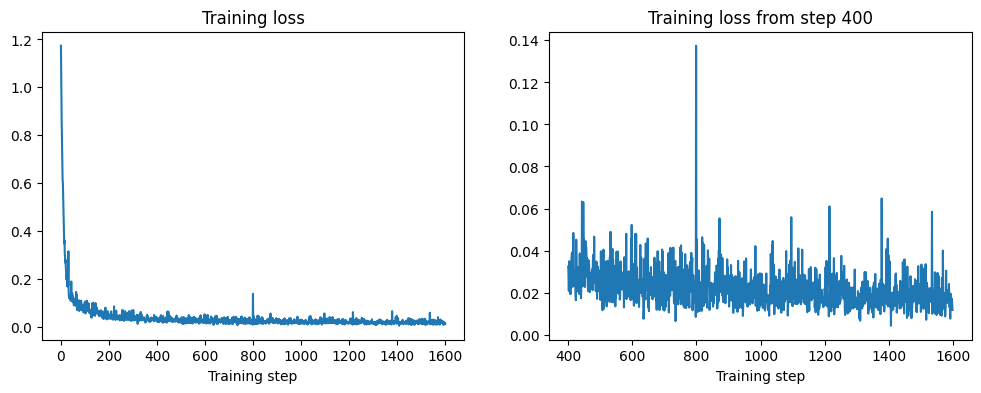

In [ ]:
plt.plot(losses)
plt.title("Training loss")
plt.xlabel("Training step");

###Sampling

We now have a model that expects two inputs when making predictions:

1. the image
2. the class label

  0%|          | 0/1000 [00:00<?, ?it/s]

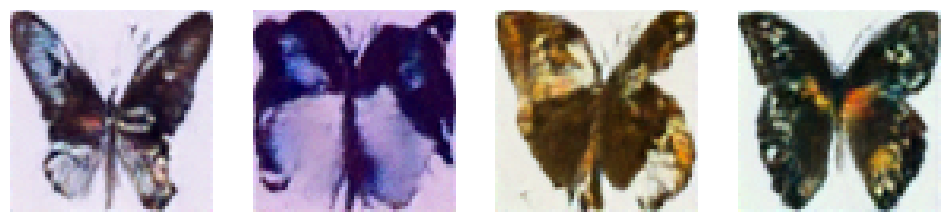

In [ ]:
def generate_from_class(class_to_generate, n_samples=8):
    sample = torch.randn(n_samples, 1, 32, 32).to(device)
    class_labels = [class_to_generate] * n_samples
    class_labels = torch.tensor(class_labels).to(device)

    for _, t in tqdm(enumerate(scheduler.timesteps)):
        # Get model prediction
        with torch.inference_mode():
            noise_pred = model(sample, t, class_labels=class_labels).sample

        # Update sample with step
        sample = scheduler.step(noise_pred, t, sample).prev_sample

    return sample.clip(-1, 1) * 0.5 + 0.5

# let’s do inference and generate some t-shirts (class 0)
images = generate_from_class(0)
show_images(images, nrows=2)

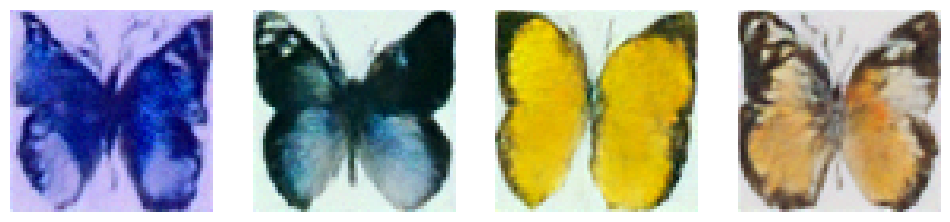

In [ ]:
# let’s generate some sneakers (class 7)
images = generate_from_class(7)
show_images(images, nrows=2)

In [ ]:
# let’s generate some boots (class 9)
images = generate_from_class(7)
show_images(images, nrows=2)

In [ ]:
# let’s generate some frock (class 3)
images = generate_from_class(3)
show_images(images, nrows=2)

##Stable Diffusion: Components in Depth

In [ ]:
from diffusers import StableDiffusionPipeline
import torch

model_id = "sd-legacy/stable-diffusion-v1-5"
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipe = pipe.to("cuda")

  0%|          | 0/50 [00:00<?, ?it/s]

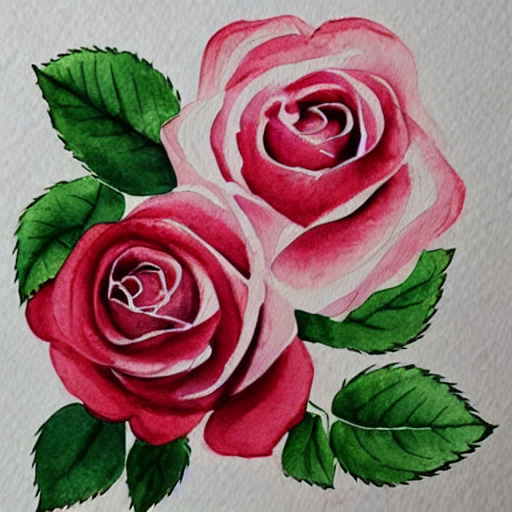

In [16]:
pipe("Watercolor illustration of a rose").images[0]

  0%|          | 0/50 [00:00<?, ?it/s]

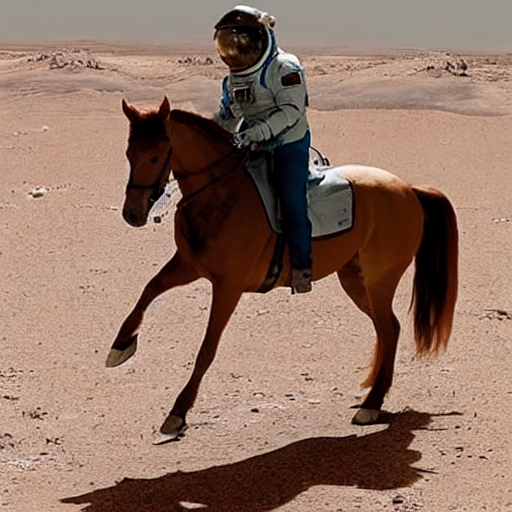

In [17]:
prompt = "a photo of an astronaut riding a horse on mars"
image = pipe(prompt).images[0]
image

In [ ]:

pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-inpainting",
    torch_dtype=torch.float16,
)
pipe.to("cuda")

In [ ]:
!wget https://machinelearningmastery.com/wp-content/uploads/2024/04/inpaint-example.png
!wget https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo_mask.png

In [25]:
image = Image.open("inpaint-example.png").convert("RGB")
mask_image = Image.open("overture-creations-5sI6fQgYIuo_mask.png")

  0%|          | 0/50 [00:00<?, ?it/s]

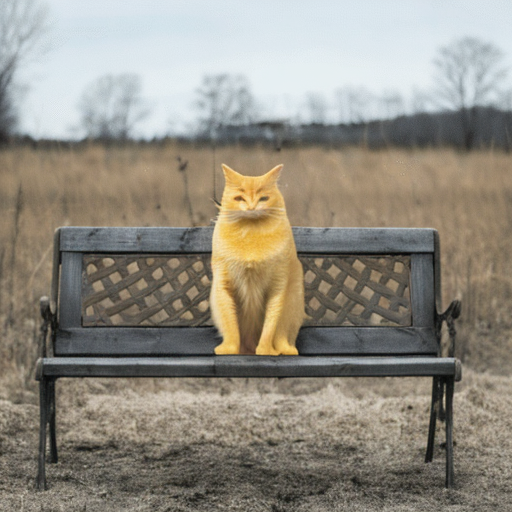

In [26]:
prompt = "Face of a yellow cat, high resolution, sitting on a park bench"
image = pipe(prompt=prompt, image=image, mask_image=mask_image).images[0]
image

###Text Encoder

In [ ]:
class BasicUNet(nn.Module):
  """A minimal UNet implementation."""
  def __init__(self, in_channels=1, out_channels=1):
    super().__init__()
    self.down_layers = nn.ModuleList(
        [
            nn.Conv2d(in_channels, 32, kernel_size=5, padding=2),
            nn.Conv2d(32, 64, kernel_size=5, padding=2),
            nn.Conv2d(64, 64, kernel_size=5, padding=2),
        ]
    )
    self.up_layers = nn.ModuleList(
        [
            nn.ConvTranspose2d(64, 64, kernel_size=5, padding=2),
            nn.ConvTranspose2d(64, 32, kernel_size=5, padding=2),
            nn.ConvTranspose2d(32, out_channels, kernel_size=5, padding=2),
        ]
    )
    # Use the SiLU activation function, which has been shown to work well
    # due to different properties (smoothness, non-monotonicity, etc.).
    self.act = nn.SiLU()
    self.downscale = nn.MaxPool2d(2)
    self.upscale = nn.Upsample(scale_factor=2)

  def forward(self, x):
    h = []
    for i , l in enumerate(self.down_layers):
      x = self.act(l(x))
      if i < 2:  # For all but the third (final) down layer
        h.append(x) # Storing output for skip connection
        x = self.downscale(x) # Downscale ready for the next layer
    for i, l in enumerate(self.up_layers):
      # For all except the first up layer
      if i > 0:
        x = self.upscale(x) # Upscale
        x += h.pop() # Fetching stored output (skip connection)
      x = self.act(l(x))
    return x

###Exploring data

In [ ]:
# loading the data with the datasets library
dataset = load_dataset("mnist")

In [ ]:
image_size = 32
batch_size = 8

def transform(examples):
  examples = [preprocess(image) for image in examples["image"]]
  return {"images": examples}

dataset.set_transform(transform)

# Define data augmentations
preprocess = transforms.Compose(
    [
        transforms.Resize((image_size,image_size)),
        transforms.ToTensor(),
    ]
)

train_dataloader = torch.utils.data.DataLoader(
    dataset["train"], batch_size=batch_size, shuffle=True
)

Input shape: torch.Size([8, 1, 32, 32])


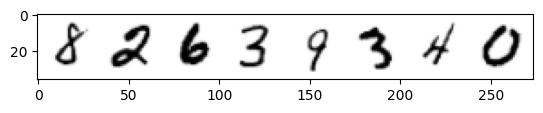

In [ ]:
imgs = next(iter(train_dataloader))["images"]
print("Input shape:", imgs.shape)
plt.imshow(torchvision.utils.make_grid(imgs)[0], cmap="Greys");

###Corruption

In [ ]:
# Let's add some amount of configurable noise to the input images
def corrupt(x, noise, amount):
  amount = amount.view(-1, 1, 1, 1) # make sure it's broadcastable
  # equivalent to x.lerp(noise, amount)
  return (x * (1 - amount) + noise * amount)

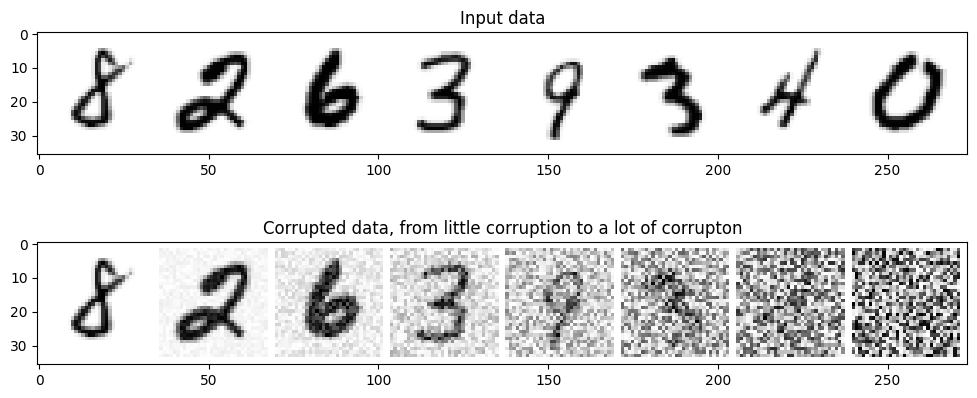

In [ ]:
# Let's visualize the effect of applying noise to the images.

# Plotting the input data
fig, axs = plt.subplots(2, 1, figsize=(12, 5))
axs[0].set_title("Input data")
axs[0].imshow(torchvision.utils.make_grid(imgs)[0], cmap="Greys")

# Adding noise (we go from little corruption to a lot)
amount = torch.linspace(0, 1, imgs.shape[0])
noise = torch.rand_like(imgs)
noised_x = corrupt(imgs, noise, amount)

# Plotting the noised version
axs[1].set_title("Corrupted data, from little corruption to a lot of corrupton")
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0], cmap="Greys")

### Basic UNet

We begin by using a minimal UNet. Some details about this UNet

- Works with single-chanel images, such as grayscale images.
- Has a downscaling and an upscaling path, each with three layers
- Each layer consists on a convolution and an activation (nn.SiLU) followed by a downscaling or upscaling step. Note that neither the last layer of the downscaling nor the first layer of the upscaling perform the down or upscaling.
- There are skip connections between downsampling and upsampling blocks.

Let's verify that the output shape is the same as the input:

In [ ]:
net = BasicUNet()
x = torch.rand(8, 1, 32, 32)
print(net(x).shape)

torch.Size([8, 1, 32, 32])


### Training model

Let's recall the process. For each training step, we:

1. Load a batch of images,
2. Add noise to the images,
3. Feed the noisy images into the model,
4. Calculate the loss.
5. Backpropagate and update weights with the optimizer.

In [ ]:
device = get_device()
num_epochs = 5  # How many runs through the data should we do?
batch_size = 128


train_dataloader = torch.utils.data.DataLoader(
    dataset["train"], batch_size=batch_size, shuffle=True
)

model = BasicUNet().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
losses = []  # Somewhere to store the loss values for later plotting

# Train the model
for epoch in range(num_epochs):
    for batch in train_dataloader:
        # Load the input images
        clean_images = batch["images"].to(device)

        # Sample noise to add to the images
        noise = torch.rand_like(clean_images).to(device)

        # Sample amount of noise to add to the images
        # In the chapter, we use the noise scheduler to manage this
        # as we can pass the timestep. Here, we keep it simple and
        # just sample a random amount of noise to add to the images.
        noise_amount = torch.randn(clean_images.shape[0]).to(device)

        # Add noise to the clean images according to the noise magnitude
        noisy_x = corrupt(clean_images, noise, noise_amount)

        # Get the model prediction
        pred = model(noisy_x)

        # Compare the prediction with the actual image
        # Big note: in the book, we optimize the model to reduce difference
        # the generation and the noise, so the model learns to predict the noise.
        # Here, we calculate the loss between the image and the generation, so the
        # model learns to generate the images directly.
        loss = F.mse_loss(pred, clean_images)

        # Update the model parameters with the optimizer based on this loss
        opt.zero_grad()
        loss.backward()
        opt.step()

        # Store the loss for later plotting
        losses.append(loss.item())

    # Print our the average of the loss values for this epoch:
    avg_loss = sum(losses[-len(train_dataloader) :]) / len(train_dataloader)
    print(f"Finished epoch {epoch}. Average loss for this epoch: {avg_loss:05f}")

Finished epoch 0. Average loss for this epoch: 0.023779
Finished epoch 1. Average loss for this epoch: 0.012413
Finished epoch 2. Average loss for this epoch: 0.011336
Finished epoch 3. Average loss for this epoch: 0.010715
Finished epoch 4. Average loss for this epoch: 0.010103


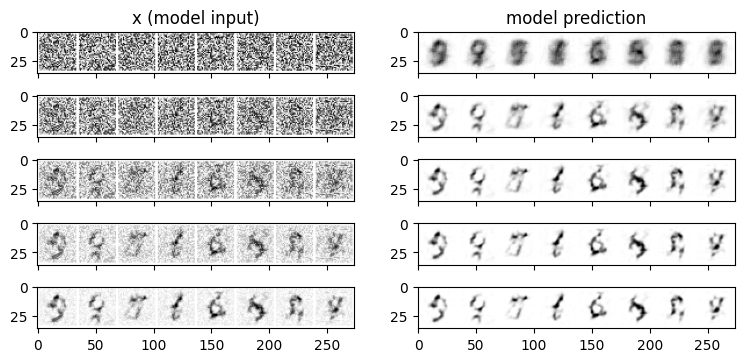

In [ ]:
n_steps = 5
x = torch.rand(8, 1, 32, 32).to(device)  # Start from random
step_history = [x.detach().cpu()]
pred_output_history = []

for i in range(n_steps):
    # Predict denoise image
    with torch.no_grad():
        pred = model(x)

    # Store output for plotting
    pred_output_history.append(pred.detach().cpu())

    # Move slightly towards that direction
    mix_factor = 1 / (n_steps - i)
    x = x * (1 - mix_factor) + pred * mix_factor

    # Store output for plotting
    step_history.append(x.detach().cpu())

fig, axs = plt.subplots(n_steps, 2, figsize=(9, 4), sharex=True)
axs[0, 0].set_title("x (model input)")
axs[0, 1].set_title("model prediction")
for i in range(n_steps):
    axs[i, 0].imshow(
        torchvision.utils.make_grid(step_history[i])[0].clip(0, 1), cmap="Greys"
    )
    axs[i, 1].imshow(
        torchvision.utils.make_grid(pred_output_history[i])[0].clip(0, 1),
        cmap="Greys",
    )

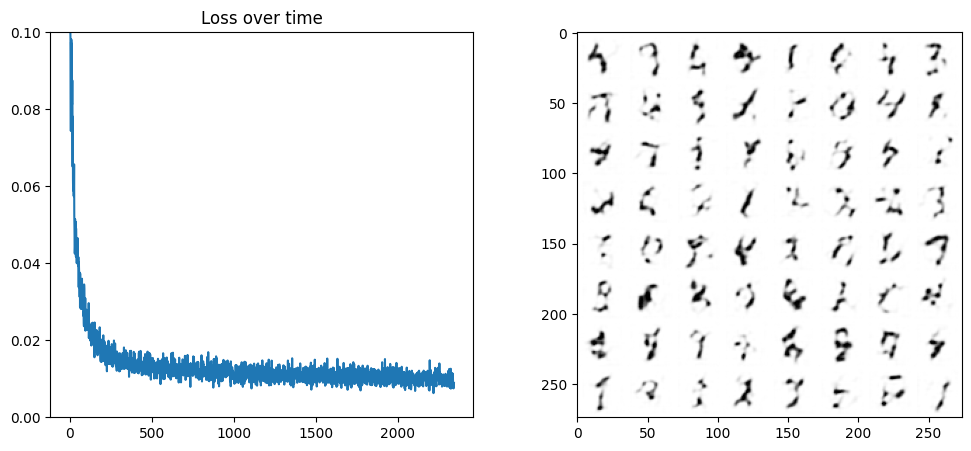

In [ ]:
# Plot losses and some samples
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Losses
axs[0].plot(losses)
axs[0].set_ylim(0, 0.1)
axs[0].set_title("Loss over time")

# Samples
n_steps = 40
x = torch.rand(64, 1, 32, 32).to(device)
for i in range(n_steps):
    noise_amount = torch.ones((x.shape[0],)).to(device) * (
        1 - (i / n_steps)
    )  # Starting high going low
    with torch.no_grad():
        pred = model(x)
    mix_factor = 1 / (n_steps - i)
    x = x * (1 - mix_factor) + pred * mix_factor
axs[1].imshow(
    torchvision.utils.make_grid(x.detach().cpu(), nrow=8)[0].clip(0, 1),
    cmap="Greys",
)

In [ ]:
basic_losses = losses
basic_model = model

###Diffusers UNet

Let's now use the diffusers library UNet implementation. This integrates a couple of additions:

- More parameters (e.g. by having two convolutional layers per block)
- Batch normalization, which helps learn more quickly and reliably.
- Self-attention layers that allow to focus on different pars of the images at different times.

In [ ]:
model = UNet2DModel(
    sample_size=32,
    in_channels=1,
    out_channels=1,
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(32, 64, 64),  # Roughly matching our basic unet example
    down_block_types=(
        "DownBlock2D",
        "AttnDownBlock2D",
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",
        "UpBlock2D",
    ),
).to(device)

In [ ]:
sum(
    [p.numel() for p in model.parameters()]
)  # 1.7M vs the ~309k parameters of the BasicUNet

1707009

In [ ]:
# As this model is larger, the training will take a bit longer.
batch_size = 128
train_dataloader = DataLoader(
    dataset["train"], batch_size=batch_size, shuffle=True
)
num_epochs = 5

train_dataloader = torch.utils.data.DataLoader(
    dataset["train"], batch_size=batch_size, shuffle=True
)

opt = torch.optim.Adam(model.parameters(), lr=1e-3)
losses = []  # Somewhere to store the loss values for later plotting

# Train the model
for epoch in range(num_epochs):
    for batch in train_dataloader:
        # Load the input images
        clean_images = batch["images"].to(device)

        # Sample noise to add to the images
        noise = torch.rand_like(clean_images).to(device)

        # Sample amount of noise to add to the images
        noise_amount = torch.randn(clean_images.shape[0]).to(device)

        # Add noise to the clean images according to the noise magnitude
        noisy_x = corrupt(clean_images, noise, noise_amount)

        # Get the model prediction using timestep 0
        pred = model(noisy_x, 0).sample

        # Compare the prediction with the actual image
        # Big note: in the book, we optimize the model to reduce difference
        # the generation and the noise, so the model learns to predict the noise.
        # Here, we calculate the loss between the image and the generation, so the
        # model learns to generate the images directly.
        loss = F.mse_loss(pred, clean_images)

        # Update the model parameters with the optimizer based on this loss
        opt.zero_grad()
        loss.backward()
        opt.step()

        # Store the loss for later plotting
        losses.append(loss.item())

    # Print our the average of the loss values for this epoch:
    avg_loss = sum(losses[-len(train_dataloader) :]) / len(train_dataloader)
    print(
        f"Finished epoch {epoch}. Average loss for this epoch: {avg_loss:05f}"
    )

Finished epoch 0. Average loss for this epoch: 0.012445
Finished epoch 1. Average loss for this epoch: 0.006969
Finished epoch 2. Average loss for this epoch: 0.006010
Finished epoch 3. Average loss for this epoch: 0.005719
Finished epoch 4. Average loss for this epoch: 0.005417


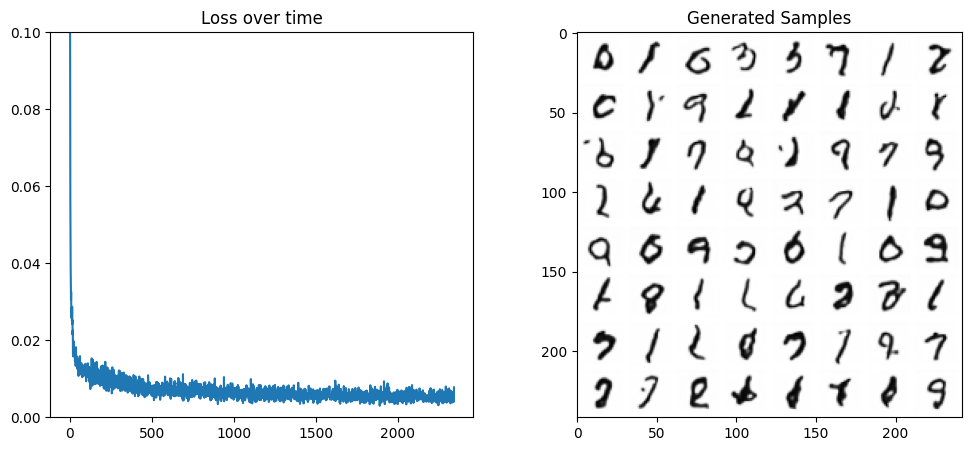

In [ ]:
# Plot losses and some samples
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Losses
axs[0].plot(losses)
axs[0].set_ylim(0, 0.1)
axs[0].set_title("Loss over time")

# Samples
n_steps = 40
x = torch.rand(64, 1, 28, 28).to(device)
for i in range(n_steps):
    noise_amount = torch.ones((x.shape[0],)).to(device) * (
        1 - (i / n_steps)
    )  # Starting high going low
    with torch.no_grad():
        pred = model(x, 0).sample
    mix_factor = 1 / (n_steps - i)
    x = x * (1 - mix_factor) + pred * mix_factor

axs[1].imshow(
    torchvision.utils.make_grid(x.detach().cpu(), nrow=8)[0].clip(0, 1),
    cmap="Greys",
)
axs[1].set_title("Generated Samples");

Much better! Still, not perfect, but a great improvement for a model we can quickly train.

Plot losses together with the ones from the previous model.

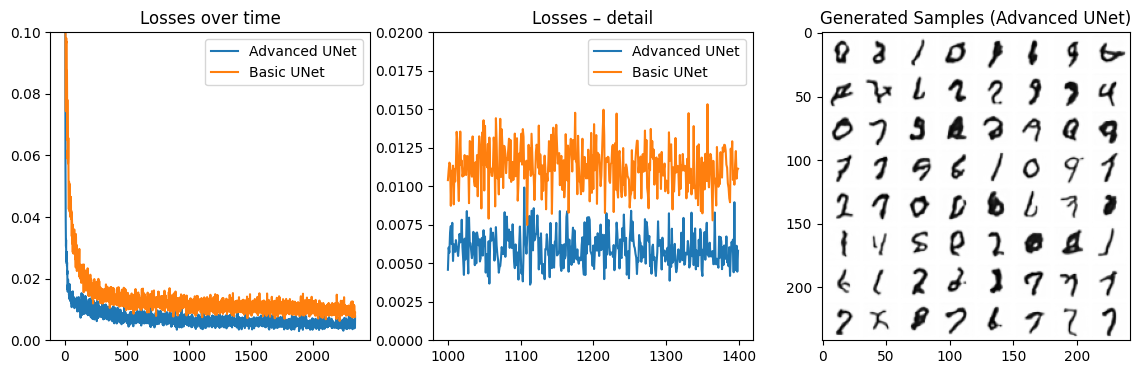

In [ ]:
# Plot losses and some samples
fig, axs = plt.subplots(1, 3, figsize=(14, 4))
import numpy as np

# Losses
axs[0].plot(losses, label="Advanced UNet")
axs[0].plot(basic_losses, label="Basic UNet")
axs[0].set_ylim(0, 0.1)
axs[0].set_title("Losses over time")
axs[0].legend()

# Losses
axs[1].plot(losses[1000:1400], label="Advanced UNet")
axs[1].plot(basic_losses[1000:1400], label="Basic UNet")
axs[1].set_ylim(0, 0.02)
axs[1].set_title("Losses – detail")
axs[1].set_xticks(np.arange(0, 401, step=100), np.arange(1000, 1401, step=100))
axs[1].legend()

# Samples
n_steps = 40
x = torch.rand(64, 1, 28, 28).to(device)
for i in range(n_steps):
    noise_amount = torch.ones((x.shape[0],)).to(device) * (
        1 - (i / n_steps)
    )  # Starting high going low
    with torch.no_grad():
        pred = model(x, 0).sample
    mix_factor = 1 / (n_steps - i)
    x = x * (1 - mix_factor) + pred * mix_factor

axs[2].imshow(
    torchvision.utils.make_grid(x.detach().cpu(), nrow=8)[0].clip(0, 1),
    cmap="Greys",
)
axs[2].set_title("Generated Samples (Advanced UNet)");

##Diffusion Objectives

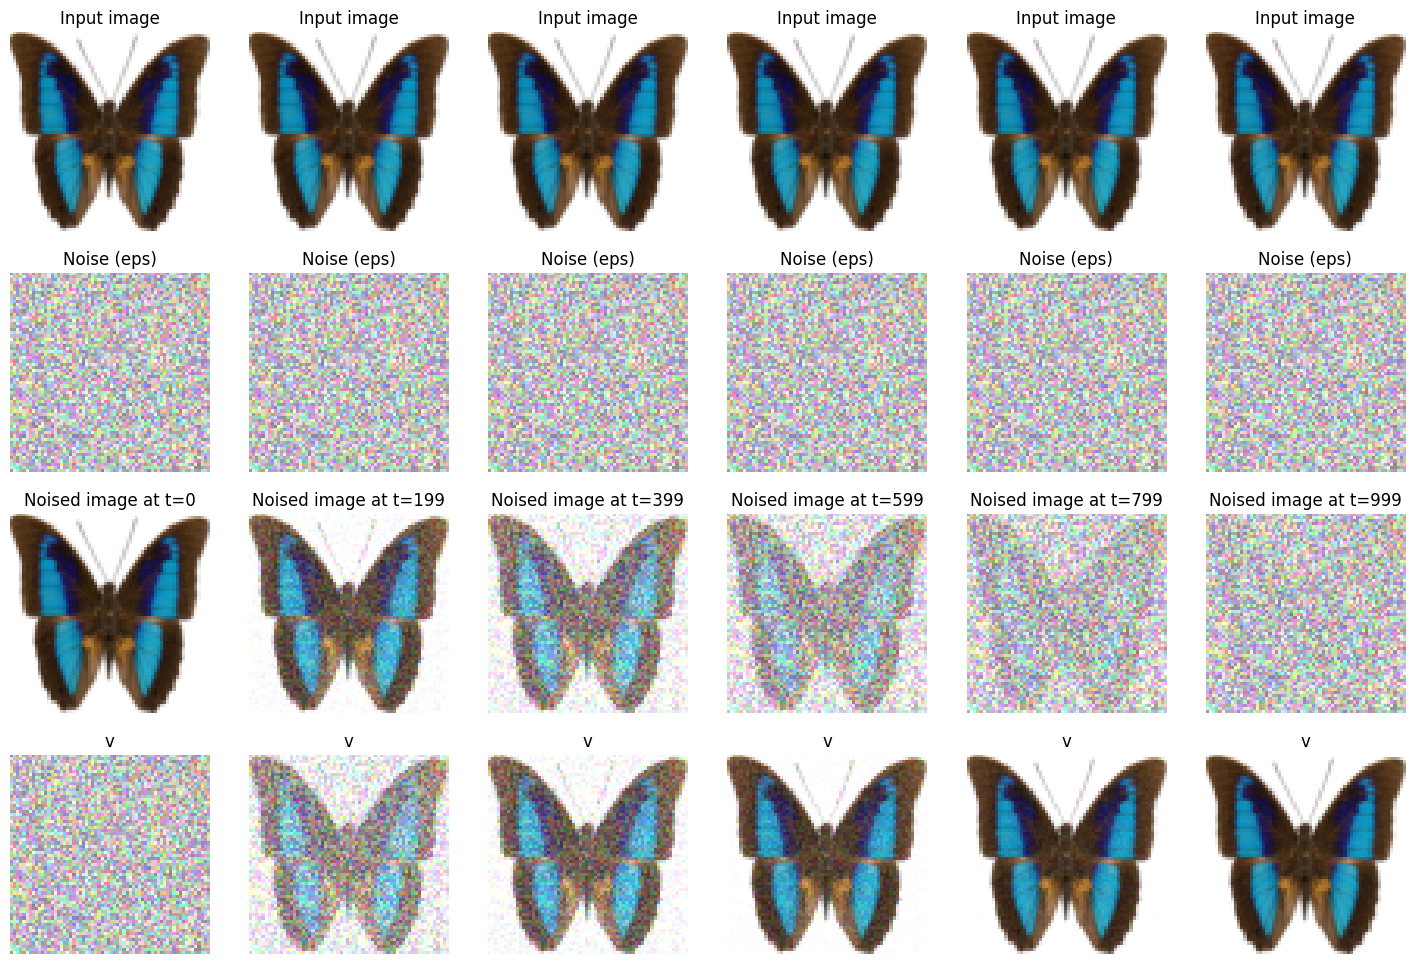

In [ ]:
# Updated for large image sizes
scheduler = DDPMScheduler(beta_end=0.012)
sample = batch["images"][0]
image_size = sample.shape[-1]
noise_size = image_size  # 32
res_transform = transforms.Resize(noise_size, antialias=True)
x = res_transform(sample.expand(6, 3, image_size, image_size))
noise = torch.rand_like(res_transform(sample)).expand(
    6, 3, noise_size, noise_size
)
timesteps = torch.linspace(0, 999, 6).long()
noised_x = scheduler.add_noise(x, noise, timesteps)
alpha_bars = scheduler.alphas_cumprod[timesteps]
v = (
    alpha_bars.view(-1, 1, 1, 1).sqrt() * noise
    + (1 - alpha_bars.view(-1, 1, 1, 1)).sqrt() * x
)
images = torch.cat(
    [
        x,
        noise,
        noised_x,
        v,
    ],
    dim=0,
)
titles = (
    ["Input image"] * 6
    + ["Noise (eps)"] * 6
    + [f"Noised image at t={t}" for t in timesteps]
    + ["v"] * 6
)

show_images(images.clip(-1, 1) * 0.5 + 0.5, ncols=6, titles=titles)